In [1]:
# Imports of all needed libraries

import pandas as pd
import numpy as np
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from apyori import apriori
from matplotlib import pyplot as plt
import matplotlib as mpl

plt.rcParams["figure.figsize"] = [10, 6] # Defines size of the plots

# df

In [2]:
# Gets data from pycaret.datasets

datasets = {
    'germany' : 'https://raw.githubusercontent.com/pycaret/datasets/main/data/common/germany.csv',
    'france'  : 'https://raw.githubusercontent.com/pycaret/datasets/main/data/common/france.csv',
}

# Read the data for Germany
df = pd.read_csv(datasets['germany'])
df

InvoiceNo StockCode                          Description  Quantity  \
0       536527     22809              SET OF 6 T-LIGHTS SANTA         6   
1       536527     84347  ROTATING SILVER ANGELS T-LIGHT HLDR         6   
2       536527     84945   MULTI COLOUR SILVER T-LIGHT HOLDER        12   
3       536527     22242        5 HOOK HANGER MAGIC TOADSTOOL        12   
4       536527     22244           3 HOOK HANGER MAGIC GARDEN        12   
...        ...       ...                                  ...       ...   
9490    581578     22993         SET OF 4 PANTRY JELLY MOULDS        12   
9491    581578     22907     PACK OF 20 NAPKINS PANTRY DESIGN        12   
9492    581578     22908        PACK OF 20 NAPKINS RED APPLES        12   
9493    581578     23215     JINGLE BELL HEART ANTIQUE SILVER        12   
9494    581578     22736          RIBBON REEL MAKING SNOWMEN         10   

          InvoiceDate  UnitPrice  CustomerID  Country  
0     12/1/2010 13:04       2.95       12662  Germany  
1     12/1/2010 13:04       2.55       12662  Germany  
2     12/1/2010 13:04       0.85       12662  Germany  
3     12/1/2010 13:04       1.65       12662  Germany  
4     12/1/2010 13:04       1.95       12662  Germany  
...               ...        ...         ...      ...  
9490  12/9/2011 12:16       1.25       12713  Germany  
9491  12/9/2011 12:16       0.85       12713  Germany  
9492  12/9/2011 12:16       0.85       12713  Germany  
9493  12/9/2011 12:16       2.08       12713  Germany  
9494  12/9/2011 12:16       1.65       12713  Germany  

[9495 rows x 8 columns]

# 1. Data processing

## 1.1 Dataset analysis

In [3]:
# Describes the given Dataset

print('Data size:', df.shape[0], 'x', df.shape[1])

Data size: 9495 x 8


In [4]:
# Describes nulls and type of the data in the given Dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9495 entries, 0 to 9494
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    9495 non-null   object 
 1   StockCode    9495 non-null   object 
 2   Description  9495 non-null   object 
 3   Quantity     9495 non-null   int64  
 4   InvoiceDate  9495 non-null   object 
 5   UnitPrice    9495 non-null   float64
 6   CustomerID   9495 non-null   int64  
 7   Country      9495 non-null   object 
dtypes: float64(1), int64(2), object(5)
memory usage: 593.6+ KB


In [5]:
# Counts a number of unique entities in each column

df.nunique()

InvoiceNo       603
StockCode      1671
Description    1703
Quantity         68
InvoiceDate     598
UnitPrice       106
CustomerID       95
Country           1
dtype: int64

In [6]:
# Counts a number of nulls in each column

null_counts = df.isnull().sum()
print(null_counts)

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


In [7]:
# Describes the given Dataset

df.describe()

Quantity    UnitPrice    CustomerID
count  9495.000000  9495.000000   9495.000000
mean     12.369458     3.966930  12646.139336
std      17.865719    16.549026    309.138487
min    -288.000000     0.000000  12426.000000
25%       5.000000     1.250000  12480.000000
50%      10.000000     1.950000  12592.000000
75%      12.000000     3.750000  12662.000000
max     600.000000   599.500000  14335.000000

## 1.2 Anomalies Check

In [8]:
# Checks for unreal values in Quantity and UnitPrice

print('N observations with Quantity lower than 0:', len(df[df['Quantity'] <= 0]))
print('N observations with UnitPrice lower than 0:', len(df[df['UnitPrice'] <= 0]))

N observations with Quantity lower than 0: 453
N observations with UnitPrice lower than 0: 2


In [9]:
# Checks if there are products with the same name, but different StockCode

c = df.groupby(by=['Description'])['StockCode'].nunique().reset_index()

print('N observations:', len(c[c['StockCode'] > 1]))
print('Product names:', c[c['StockCode'] > 1]['Description'].to_list())

N observations: 0
Product names: []


In [10]:
# Checks if there are products with the same StockCode, but different name

c = df.groupby(by=['StockCode'])['Description'].nunique().reset_index()
problematic_codes = c[c['Description'] > 1]['StockCode'].to_list()

print('N observations:', len(problematic_codes))
print('StockCodes:', problematic_codes)

N observations: 32
StockCodes: ['21232', '21507', '21928', '22129', '22179', '22197', '22383', '22466', '22584', '22595', '22776', '22900', '22939', '22985', '22986', '22999', '23196', '23203', '23209', '23231', '23232', '23236', '23237', '23240', '23396', '23545', '82486', '84828', '84997A', '84997B', '84997C', '84997D']


In [11]:
# For each problematic StockCode print a list of coresponded product names

for code in problematic_codes:
    names = df[df['StockCode']==code]['Description'].unique()
    print(code, 'is used for', names)

21232 is used for ['STRAWBERRY CERAMIC TRINKET BOX' 'STRAWBERRY CERAMIC TRINKET POT']
21507 is used for ['ELEPHANT, BIRTHDAY CARD, ' 'ELEPHANT BIRTHDAY CARD ']
21928 is used for ['JUMBO BAG SCANDINAVIAN PAISLEY' 'JUMBO BAG SCANDINAVIAN BLUE PAISLEY']
22129 is used for ['PARTY CONES CANDY TREE DECORATION' 'PARTY CONES CANDY DECORATION']
22179 is used for ['SET 10 LIGHTS NIGHT OWL' 'SET 10 NIGHT OWL LIGHTS']
22197 is used for ['SMALL POPCORN HOLDER' 'POPCORN HOLDER']
22383 is used for ['LUNCH BAG SUKI  DESIGN ' 'LUNCH BAG SUKI DESIGN ']
22466 is used for ['FAIRY TALE COTTAGE NIGHTLIGHT' 'FAIRY TALE COTTAGE NIGHT LIGHT']
22584 is used for ['PACK OF 6 PANNETONE GIFT BOXES' 'PACK OF 6 PANETTONE GIFT BOXES']
22595 is used for ['CHRISTMAS GINGHAM HEART' 'GINGHAM HEART DECORATION']
22776 is used for ['SWEETHEART CAKESTAND 3 TIER' 'SWEETHEART 3 TIER CAKE STAND ']
22900 is used for [' SET 2 TEA TOWELS I LOVE LONDON ' 'SET 2 TEA TOWELS I LOVE LONDON ']
22939 is used for ['APRON APPLE DELIGHT' 'AD

## 1.3 Data preparation

In [12]:
# Creates filters for the data to avoid "garbage" values

print('Data Size:',len(df))

df = df.loc[df['Description'] != 'Manual']
df = df.loc[df['Description'] != 'POSTAGE']
df = df.loc[df['Quantity'] > 0]
df = df.loc[df['UnitPrice'] > 0]

print('Data Size:',len(df))

Data Size: 9495
Data Size: 8658


In [13]:
# Product names unification

for code in problematic_codes:
    names = df[df['StockCode'] == code]['Description'].unique()
    df.loc[df['StockCode'] == code, 'Description'] = list(names)[0]

In [14]:
df.describe()

Quantity    UnitPrice    CustomerID
count  8658.000000  8658.000000   8658.000000
mean     13.645068     2.720593  12649.078887
std      17.885200     2.830171    313.946780
min       1.000000     0.040000  12426.000000
25%       6.000000     1.250000  12480.000000
50%      12.000000     1.650000  12600.000000
75%      12.000000     3.250000  12662.000000
max     600.000000    39.950000  14335.000000

# 2. Exploratory Data Analysis

## 2.1 Top-15 the most frequent products

Text(0.5, 0, 'N invoices')

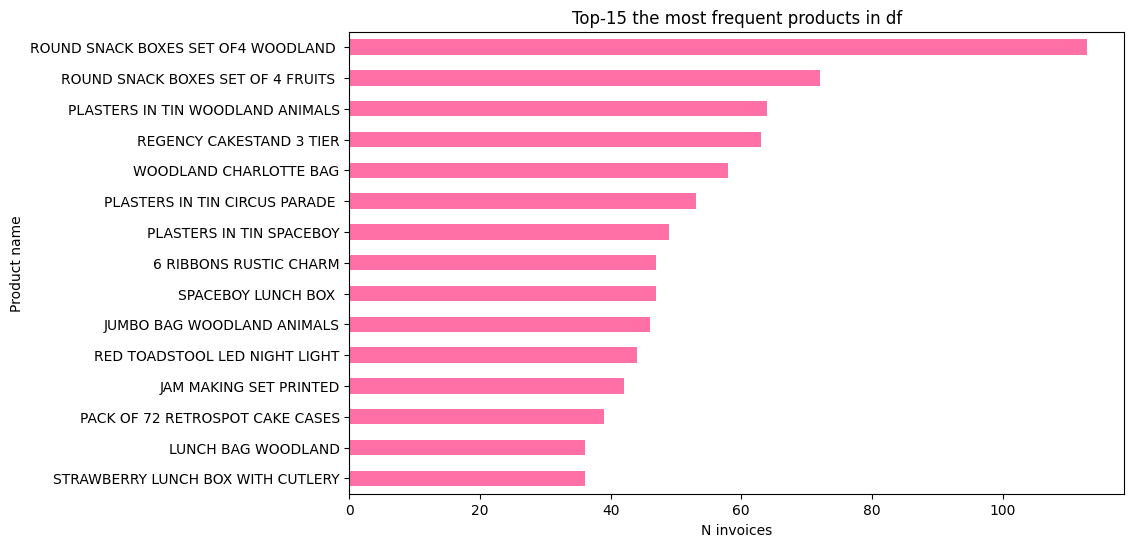

In [15]:
# Prepares the 'InvoiceNo' column for creating a plot

df_counts = df.groupby('Description')['InvoiceNo'].count().reset_index()
df_counts = df_counts.sort_values(by = ['InvoiceNo'], ascending = True)


# Selects top-15 the most frequent products

df_counts = df_counts.tail(15) # it is a tail because I have 'ascending' on the previous row


# Creates the plot

df_counts = df_counts.set_index('Description')
df_counts['InvoiceNo'].plot(kind="barh", color = '#ff70a6')
plt.title("Top-15 the most frequent products in df")
plt.ylabel("Product name")
plt.xlabel("N invoices")

## 2.2 Top-15 the best selling products

Text(0.5, 0, 'N of purchases')

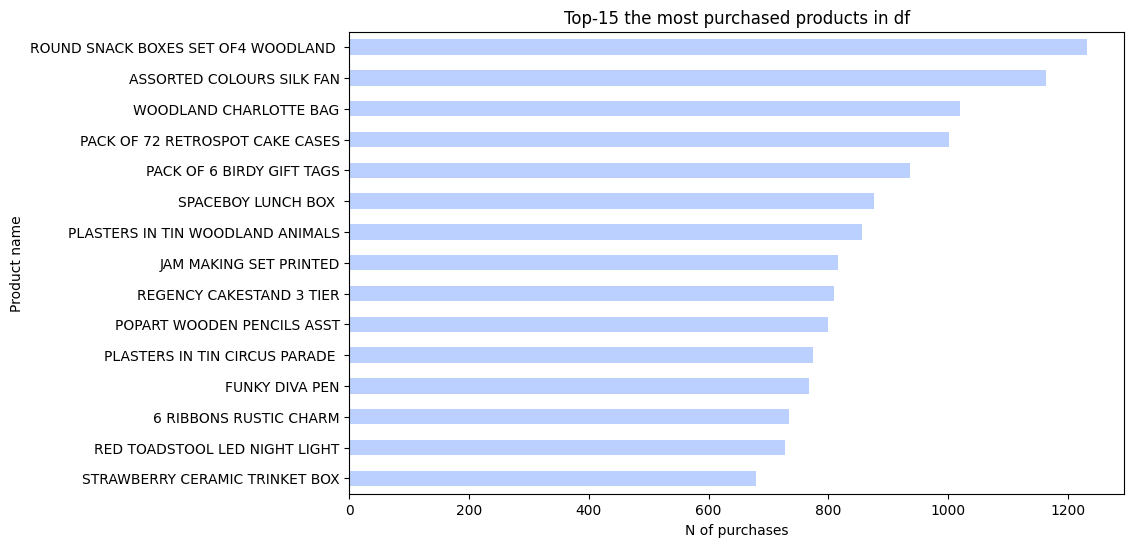

In [16]:
# Prepares the 'Quantity' column for creating a plot

df_purchased = df.groupby('Description')['Quantity'].sum().reset_index()
df_purchased = df_purchased.sort_values(by = ['Quantity'], ascending = True)


# Selects top-15 the most purchased products

best_15 = df_purchased.tail(15) # it is a tail because I have 'ascending' on the previous row


# Creates the plot

best_15 = best_15.set_index('Description')
best_15['Quantity'].plot(kind="barh", color = '#bbd0ff')
plt.title("Top-15 the most purchased products in df")
plt.ylabel("Product name")
plt.xlabel("N of purchases")

## 2.3 Destribution of items quantities in invoices

[Text(0, 1, '')]

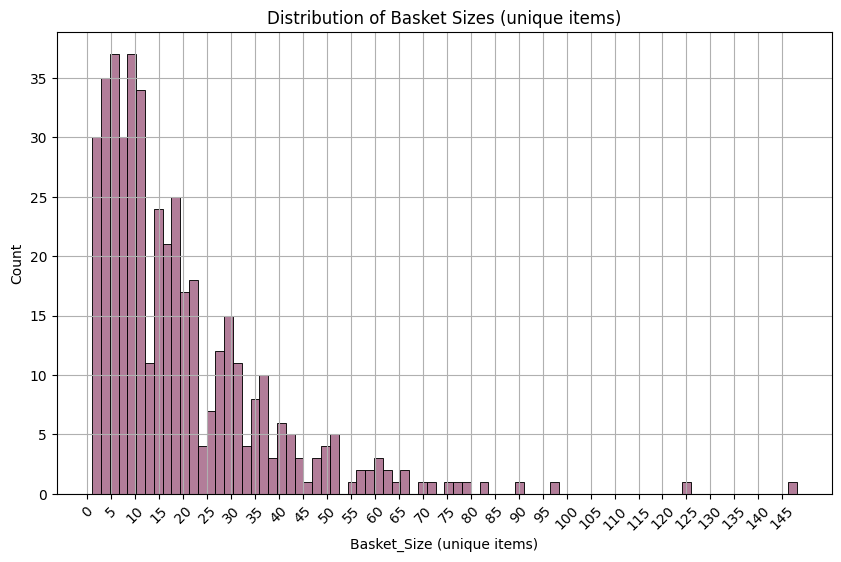

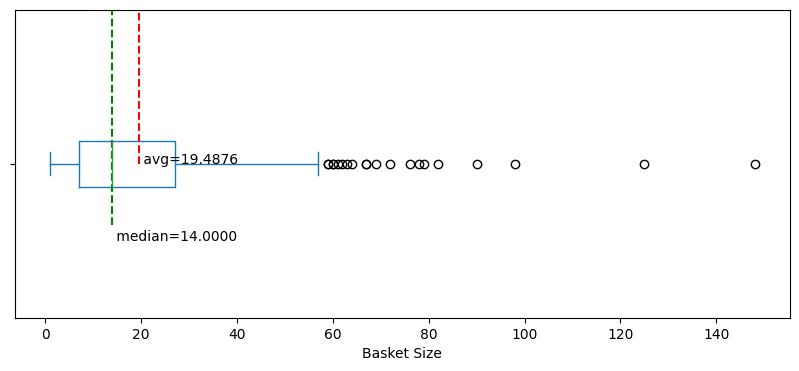

In [17]:
# Prepares columns and creates a column 'Basket_Size (unique items)' for creating a plot

unique_items_per_invoice = df.groupby('InvoiceNo')['StockCode'].nunique().reset_index()
unique_items_per_invoice.columns = ['InvoiceNo', 'Basket_Size (unique items)']


# Creates the 'Distribution of Basket Sizes (unique items)' plot

plt.title('Distribution of Basket Sizes (unique items)')
g = sns.histplot(data=unique_items_per_invoice, x="Basket_Size (unique items)", bins = 80, color = '#985277')
g.set_xticks(range(0, unique_items_per_invoice['Basket_Size (unique items)'].max(), 5)) 
g.set_xticklabels(g.get_xticklabels(), rotation=45, size = 10)
plt.grid(True)


# Calculates a mean and a median for a boxplot

avg_basket_size = unique_items_per_invoice['Basket_Size (unique items)'].mean()
median_basket_size = unique_items_per_invoice['Basket_Size (unique items)'].median()


# Creates the "Basket Size" boxplot

ax = unique_items_per_invoice.plot.box(vert=False, figsize=(10, 4))

ax.axvline(avg_basket_size, 0.5, 1, linestyle="--", label="mean", color="red")
ax.text(avg_basket_size, 1, f" avg={avg_basket_size:.4f}")

ax.axvline(median_basket_size, 0.3, 1, linestyle="--", label="mean", color="green")
ax.text(median_basket_size, 0.75, f" median={median_basket_size:.4f}")

ax.set_xlabel("Basket Size")
ax.set_yticklabels([])

[Text(0, 1, '')]

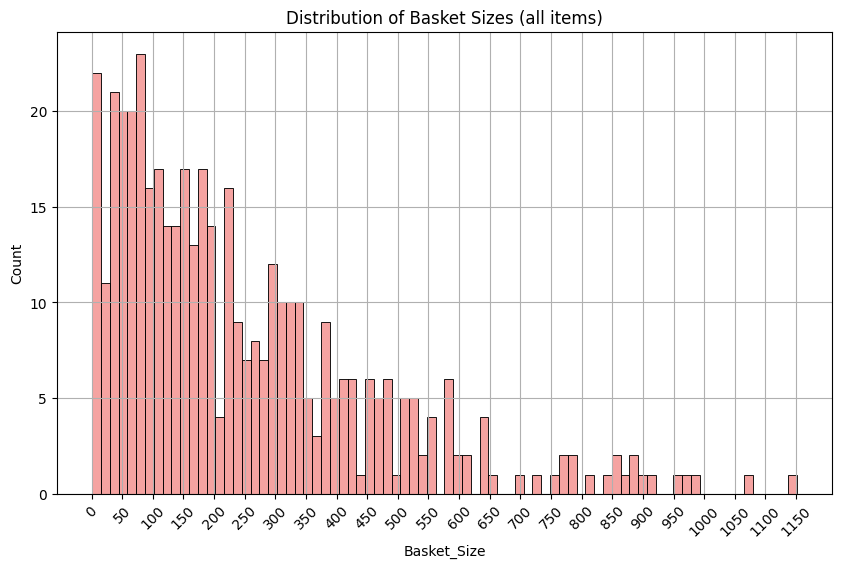

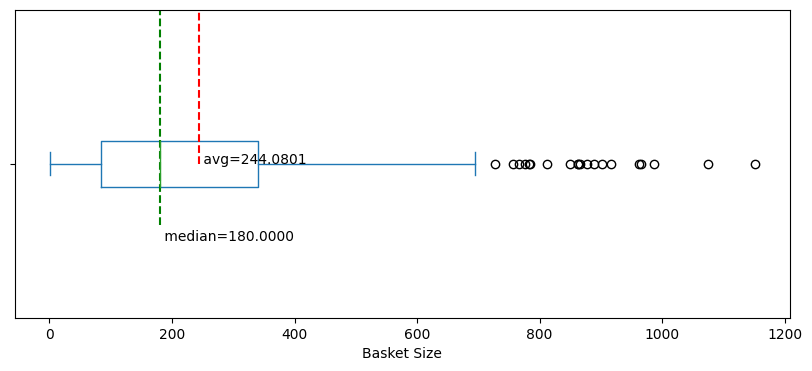

In [18]:
# Prepares columns and creates a column 'Basket_Size' for creating a plot

total_items_per_invoice = df.groupby('InvoiceNo')['Quantity'].sum().reset_index()
total_items_per_invoice.columns = ['InvoiceNo', 'Basket_Size']
total_items_per_invoice = total_items_per_invoice[total_items_per_invoice['Basket_Size']<=1200]


# Creates the 'Distribution of Basket Sizes (all items)' plot

plt.title('Distribution of Basket Sizes (all items)')
g = sns.histplot(data=total_items_per_invoice, x="Basket_Size", bins = 80, color = '#f28482')
g.set_xticks(range(0, total_items_per_invoice['Basket_Size'].max(), 50)) 
g.set_xticklabels(g.get_xticklabels(), rotation=45, size = 10)
plt.grid(True)


# Calculates a mean and a median for a boxplot

avg_basket_size = total_items_per_invoice['Basket_Size'].mean()
median_basket_size = total_items_per_invoice['Basket_Size'].median()


# Creates the 'Distribution of Basket Sizes (all items)' boxplot

ax = total_items_per_invoice.plot.box(vert=False, figsize=(10, 4))
ax.axvline(avg_basket_size, 0.5, 1, linestyle="--", label="mean", color="red")
ax.text(avg_basket_size, 1, f" avg={avg_basket_size:.4f}")

ax.axvline(median_basket_size, 0.3, 1, linestyle="--", label="mean", color="green")
ax.text(median_basket_size, 0.75, f" median={median_basket_size:.4f}")

ax.set_xlabel("Basket Size")
ax.set_yticklabels([])

## 2.4 Destribution of total amounts in invoices

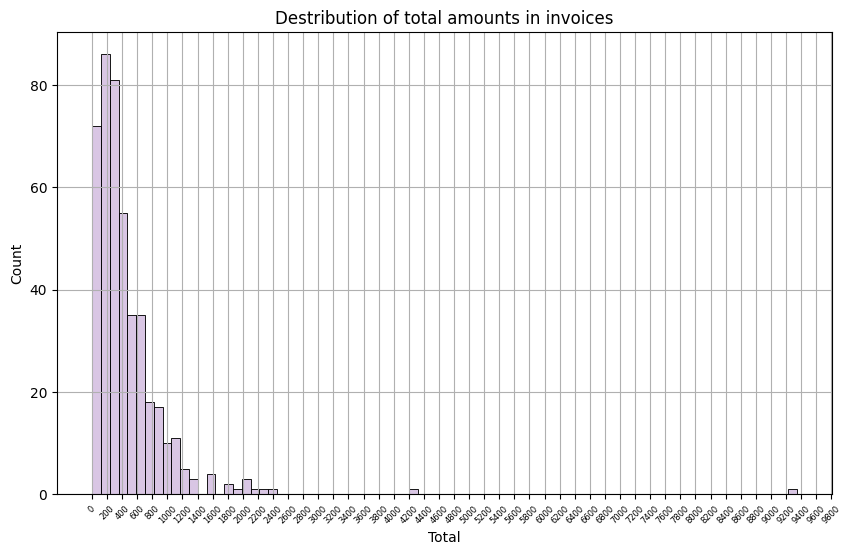

In [19]:
# Multiplies 'Quantity' and 'UnitPrice' columns to find out the total cost of each invoice

df['Total'] = df['Quantity']*df['UnitPrice']
InvoiceNo_counts = df.groupby('InvoiceNo')['Total'].sum().reset_index()


# Creates the 'Destribution of total amounts in invoices' plot

plt.title('Destribution of total amounts in invoices')
g = sns.histplot(data=InvoiceNo_counts, x="Total", bins = 80, color='#cdb4db')
g.set_xticks(range(0, 10000, 200)) 
g.set_xticklabels(g.get_xticklabels(), rotation=45, size = 6)
g = sns.color_palette("rocket", as_cmap=True)
plt.grid(True)

## 2.5 Exploring of the biggest invoices in the dataset

In [20]:
# Calculates the biggest 10 invoices with unique prodact's names

df_Invoices = df.groupby(by = ['InvoiceNo'])['Description'].nunique().reset_index()
df_Invoices = df_Invoices.sort_values('Description', ascending = False)
df_Invoices = df_Invoices.head(10)


# Creates a list to better overview

the_largest_Invoices = df_Invoices['InvoiceNo'].to_list()
the_largest_Invoices

['540458',
 '555383',
 '571328',
 '564856',
 '557466',
 '571824',
 '571065',
 '560590',
 '575886',
 '537201']

In [21]:
# Creates a subset of the biggest invoices

best_transactions = df[df['InvoiceNo'].isin(the_largest_Invoices)]
best_transactions

InvoiceNo StockCode                          Description  Quantity  \
81      537201     22781                GUMBALL MAGAZINE RACK         2   
82      537201     22865               HAND WARMER OWL DESIGN        24   
83      537201     22960             JAM MAKING SET WITH JARS        12   
84      537201     22961               JAM MAKING SET PRINTED        12   
85      537201     22962                JAM JAR WITH PINK LID        24   
...        ...       ...                                  ...       ...   
8311    575886     22558      CLOTHES PEGS RETROSPOT PACK 24          3   
8312    575886     21452                  TOADSTOOL MONEY BOX         3   
8313    575886     22061  LARGE CAKE STAND  HANGING STRAWBERY         1   
8314    575886     22059        CERAMIC STRAWBERRY DESIGN MUG         8   
8315    575886     23084                   RABBIT NIGHT LIGHT        10   

           InvoiceDate  UnitPrice  CustomerID  Country  Total  
81     12/5/2010 14:19       7.65       12472  Germany  15.30  
82     12/5/2010 14:19       2.10       12472  Germany  50.40  
83     12/5/2010 14:19       3.75       12472  Germany  45.00  
84     12/5/2010 14:19       1.45       12472  Germany  17.40  
85     12/5/2010 14:19       0.85       12472  Germany  20.40  
...                ...        ...         ...      ...    ...  
8311  11/11/2011 13:57       1.65       12517  Germany   4.95  
8312  11/11/2011 13:57       2.95       12517  Germany   8.85  
8313  11/11/2011 13:57       9.95       12517  Germany   9.95  
8314  11/11/2011 13:57       1.49       12517  Germany  11.92  
8315  11/11/2011 13:57       2.08       12517  Germany  20.80  

[930 rows x 9 columns]

In [22]:
# Finds unique product's names in the bigest invoices

product = best_transactions.groupby(by = 'Description')['InvoiceNo'].nunique().reset_index()


# Finds out top frequent products in the biggest invoices

product['Ratio'] = product['InvoiceNo']/len(the_largest_Invoices) # product name per each the biggest inoice
product = product.sort_values(by = ['Ratio'], ascending = False)
product

Description  InvoiceNo  Ratio
443  ROUND SNACK BOXES SET OF4 WOODLAND           7    0.7
397             RED RETROSPOT MINI CASES          6    0.6
371     PLASTERS IN TIN WOODLAND ANIMALS          6    0.6
412        RED TOADSTOOL LED NIGHT LIGHT          5    0.5
441   ROUND SNACK BOXES SET OF 4 FRUITS           5    0.5
..                                   ...        ...    ...
34          ANTIQUE SILVER T-LIGHT GLASS          1    0.1
35    ASS FLORAL PRINT MULTI SCREWDRIVER          1    0.1
36         ASSORTED COLOUR BIRD ORNAMENT          1    0.1
38             ASSORTED EASTER GIFT TAGS          1    0.1
39        ASSTD DESIGN 3D PAPER STICKERS          1    0.1

[617 rows x 3 columns]

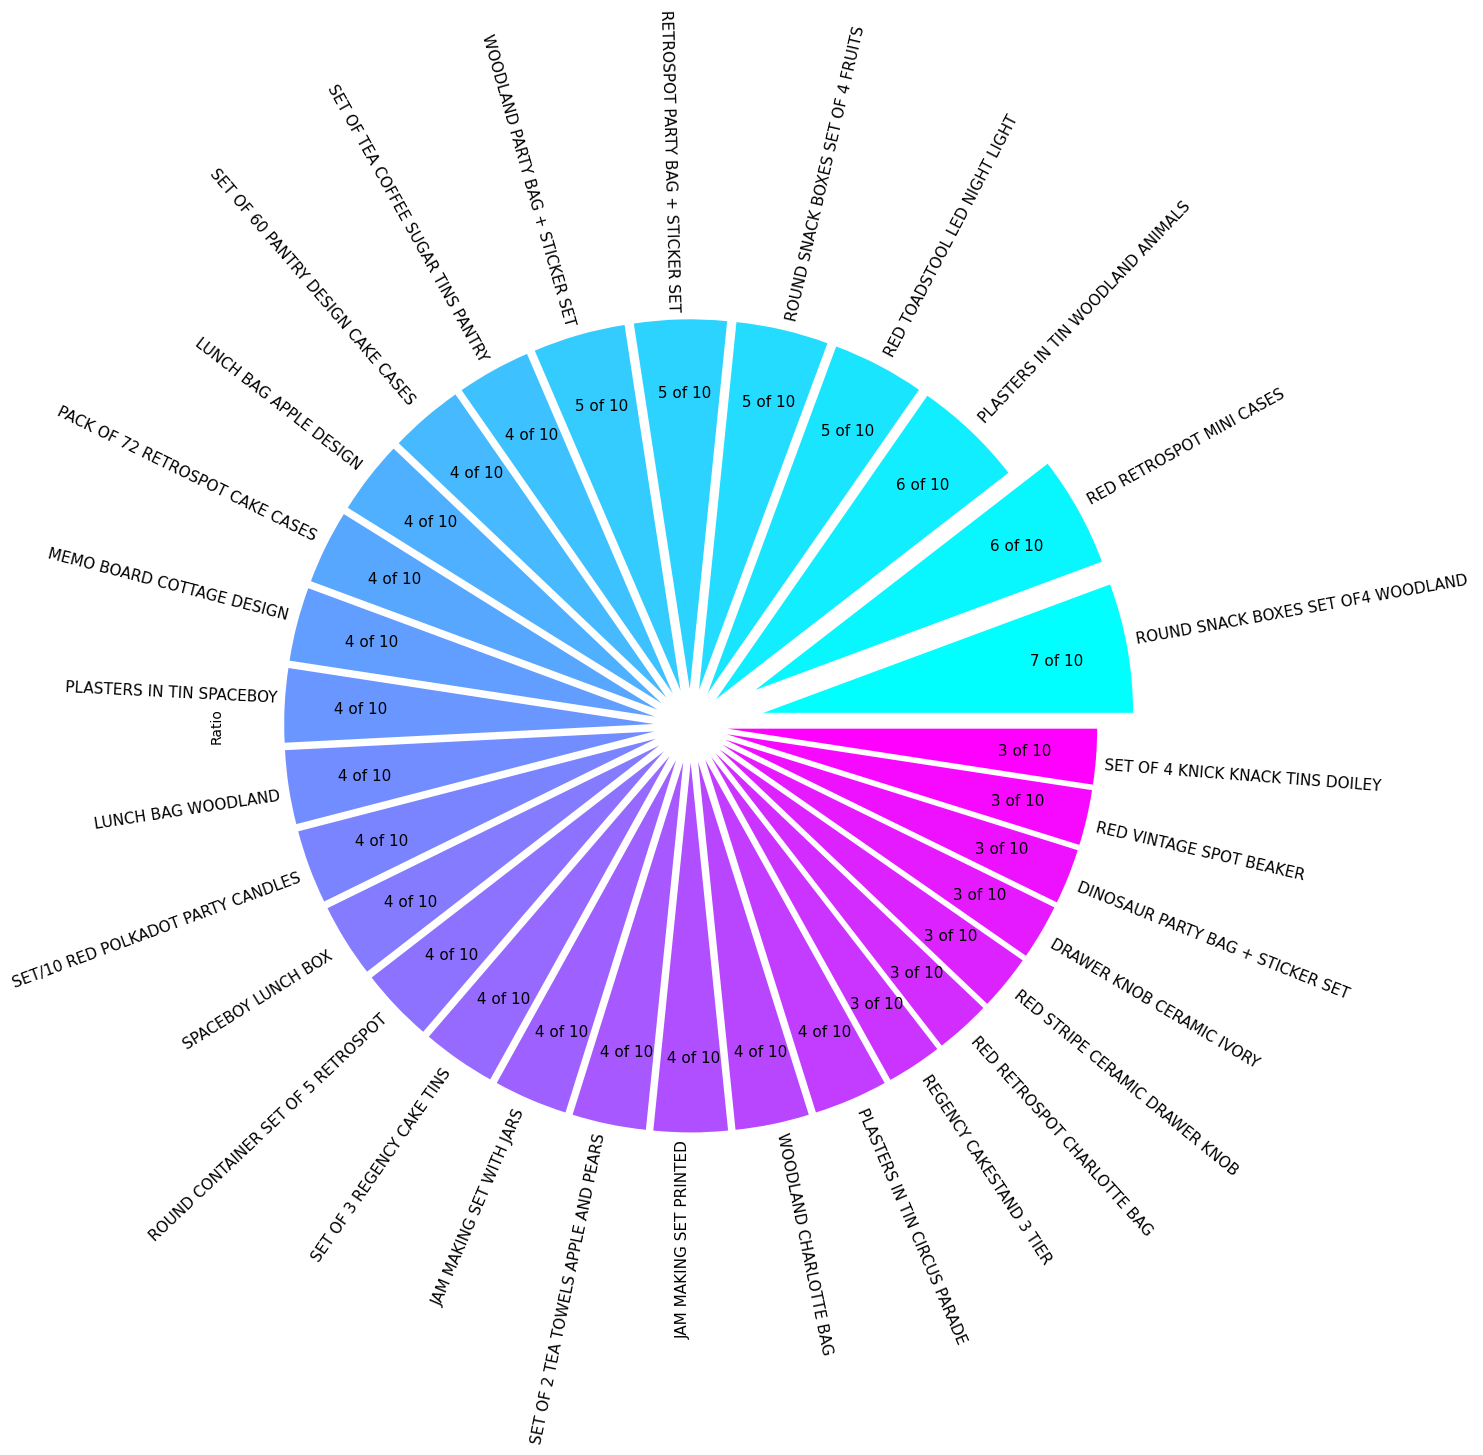

In [23]:
# Prepares the subset for creating a plot with top-30 the most frequent products in the top-10 biggest invoices

for_plot = product.set_index('Description')
top30 = for_plot.head(30)


# Creates a pie plot 

ax = top30.plot(
    kind = 'pie', 
    cmap = "cool",
    explode = [0.2] * 2 + [0.1] * (len(top30)-2),
    figsize = (12, 12),
    autopct = lambda pct: f" {pct*0.01*top30['InvoiceNo'].sum():.0f} of {len(the_largest_Invoices)}",
    pctdistance = 0.8,
    labeldistance = 1.02,
    rotatelabels = True,
    textprops = {"size": 11},
    y = 'Ratio')


ax.legend().remove() # removing a legend because it does not make sence in this case

# 3. Apriori

In [24]:
# Prepares the dataset for emplementing the Apriori algorithm.
# Uses unstack() command to reverse a dataset. Column "Description" with product's names
# became a set of new columns, where each column name equals to each product's name.
# It needed for emplementing Apriori algorithm

df_for_apriori = df.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().reset_index()
df_for_apriori = df_for_apriori.fillna(0).set_index('InvoiceNo')


# Creates a loop to have only boolean integer values or nan values

for col in df_for_apriori.columns:
    df_for_apriori[col] = df_for_apriori[col].astype(bool).astype(int)
    df_for_apriori[col] = df_for_apriori[col].apply(lambda x: col if x==1 else np.nan)

    
# Creates a subset to revert type of the data to a string.
# It needed for emplementing Apriori algorithm.

records = df_for_apriori.astype(str).values


# Implements the Apriori algorithm.

association_rules = apriori(
    records, 
    
    min_support=10/len(records), #0.022
    # Support is the ratio of the number of transactions in which item x appears
    # to the total number of transactions.
    # So the minimum support can be calculated as 10/443 = 0.022
    # To find the value we are interested that product was sold at a least in 10 Invoces
    # Then we calculate the ratio of min_n_invoces to all invoces. 
    # So products with lower Support won't be used
    
    min_confidence=0.5, #0,5
    # Confidence (x => y) signifies the likelihood of the item y being purchased when item x is purchased
    # Having the theoretical overview of the Apriori algorithm, we have to have the confidence threshold = 0.5.
    
    min_lift=3, 
    # Lift (x => y) is nothing but the ‘interestingness’ or the likelihood of the item y being purchased 
    # when item x is sold
    # Based on experiments, I found 3 as an optimal value
    
    min_length=2)
    # I consider the minimum length as 2 because I need to find an association among at least two items




association_results = list(association_rules)
print(f"There are {len(association_results)} Relation derived.")

There are 256 Relation derived.


In [25]:
# Transformation of the results into tabular form (DataFrame)
it1=[]
it2=[]
conn=[]
Support=[]
Confidence=[]
Lift=[]

# For loop to create df columns
for item in association_results:
    pair = item[0]
    items = [x for x in pair]
   
    it1.append(items[0])
    conn.append(" -> ")
    it2.append(items[1])

    Support.append(item[1])
    Confidence.append(item[2][0][2])
    Lift.append(item[2][0][3])
    
# Transforms lists into DataFrame
results = pd.DataFrame(data = {'Item1': it1, '->': conn,'Item2': it2, 'Support':Support, 'Confidence':Confidence, 'Lift':Lift})
results = results[results['Item1']!= 'nan'] # Romove useless pairs
results = results[results['Item2']!= 'nan'] # Romove useless pairs
results = results.drop_duplicates(subset = ['Item1', 'Item2']) # Drops duplicates (if any)
results 

Item1    ->  \
0                 CHOCOLATE BOX RIBBONS    ->    
1                 6 RIBBONS RUSTIC CHARM   ->    
2              ALARM CLOCK BAKELIKE PINK   ->    
3             ALARM CLOCK BAKELIKE GREEN   ->    
4              ALARM CLOCK BAKELIKE PINK   ->    
..                                   ...   ...   
189  ROUND SNACK BOXES SET OF4 WOODLAND    ->    
190  ROUND SNACK BOXES SET OF4 WOODLAND    ->    
191  ROUND SNACK BOXES SET OF4 WOODLAND    ->    
195  ROUND SNACK BOXES SET OF4 WOODLAND    ->    
201          SET/6 RED SPOTTY PAPER CUPS   ->    

                                   Item2   Support  Confidence       Lift  
0                 6 RIBBONS RUSTIC CHARM  0.022573    0.588235   5.544431  
1              SCANDINAVIAN REDS RIBBONS  0.029345    0.619048   5.834853  
2             ALARM CLOCK BAKELIKE GREEN  0.022573    0.666667   9.229167  
3              ALARM CLOCK BAKELIKE RED   0.024831    0.733333  15.469841  
4              ALARM CLOCK BAKELIKE RED   0.024831    0.523810   7.251488  
..                                   ...       ...         ...        ...  
189  SET OF 2 TEA TOWELS APPLE AND PEARS  0.022573    0.909091   3.595779  
190                  SPACEBOY LUNCH BOX   0.038375    0.944444   3.735615  
191    STRAWBERRY LUNCH BOX WITH CUTLERY  0.027088    0.857143   3.390306  
195               SPACEBOY CHILDRENS CUP  0.022573    0.526316  21.196172  
201  SET/20 RED RETROSPOT PAPER NAPKINS   0.022573    0.909091  15.489510  

[106 rows x 6 columns]

In [26]:
results.describe()

Support  Confidence        Lift
count  106.000000  106.000000  106.000000
mean     0.030133    0.702162    9.847330
std      0.013530    0.146231    6.330755
min      0.022573    0.500000    3.042582
25%      0.022573    0.571429    4.312625
50%      0.027088    0.710084    8.574550
75%      0.033296    0.811756   13.903680
max      0.135440    1.000000   36.916667

# #Comments

## 1. Support

Support of item x is nothing but the ratio of the number of transactions in which item x appears to the total number of transactions.

Support = The number of transactions in which the item appears

## 2. Confidence

Confidence (x => y) signifies the likelihood of the item y being purchased when item x is purchased. This method takes into account the popularity of item x.

Confidence ((x1,x2) = >y) = Support (x1,x2,y)/Support(x1,x2)

## 3. Lift

Lift (x => y) is nothing but the ‘interestingness’ or the likelihood of the item y being purchased when item x is sold. Unlike confidence (x => y), this method takes into account the popularity of the item y.

### Lift ((x1,x2) = >y) = Support (x1,x2,y)/(Support(x1,x2)*Support(y))

- Lift (x => y) = 1 means that there is no correlation within the itemset.
- Lift (x => y) > 1 means that there is a positive correlation within the itemset, i.e., products in the itemset, x and y, are more likely to be bought together.
- Lift (x => y) < 1 means that there is a negative correlation within the itemset, i.e., products in itemset, x and y, are unlikely to be bought together.

In [27]:
# Relations with largest Lift
big_lift = results[results['Lift'] > 15].sort_values(by = ['Lift'], ascending = False, ignore_index = True)
big_lift

Item1    ->  \
0             DOLLY GIRL CHILDRENS BOWL   ->    
1              PINK VINTAGE SPOT BEAKER   ->    
2                     BLUE OWL SOFT TOY   ->    
3               RED VINTAGE SPOT BEAKER   ->    
4         BLUE SPOT CERAMIC DRAWER KNOB   ->    
5   ROUND SNACK BOXES SET OF4 WOODLAND    ->    
6    SET/10 PINK POLKADOT PARTY CANDLES   ->    
7                SPACEBOY CHILDRENS CUP   ->    
8                 EDWARDIAN PARASOL RED   ->    
9       BLUE STRIPE CERAMIC DRAWER KNOB   ->    
10     SET OF 6 SNACK LOAF BAKING CASES   ->    
11         RED SPOT CERAMIC DRAWER KNOB   ->    
12    SET OF 12 FAIRY CAKE BAKING CASES   ->    
13         RED SPOT CERAMIC DRAWER KNOB   ->    
14          CHILDRENS CUTLERY SPACEBOY    ->    
15      BLUE STRIPE CERAMIC DRAWER KNOB   ->    
16                    BLUE POLKADOT CUP   ->    
17          SET/6 RED SPOTTY PAPER CUPS   ->    
18           ALARM CLOCK BAKELIKE GREEN   ->    

                                  Item2   Support  Confidence       Lift  
0              DOLLY GIRL CHILDRENS CUP  0.024831    0.916667  36.916667  
1              BLUE VINTAGE SPOT BEAKER  0.024831    0.785714  31.642857  
2                     PINK OWL SOFT TOY  0.022573    0.666667  22.717949  
3              BLUE VINTAGE SPOT BEAKER  0.022573    0.714286  22.602041  
4   WHITE SPOT BLUE CERAMIC DRAWER KNOB  0.022573    0.769231  21.298077  
5                SPACEBOY CHILDRENS CUP  0.022573    0.526316  21.196172  
6    SET/10 BLUE POLKADOT PARTY CANDLES  0.027088    0.800000  20.847059  
7               SPACEBOY CHILDRENS BOWL  0.038375    0.894737  19.818421  
8                RED RETROSPOT UMBRELLA  0.022573    0.666667  19.688889  
9        RED STRIPE CERAMIC DRAWER KNOB  0.024831    0.846154  17.849817  
10     SET OF 12 MINI LOAF BAKING CASES  0.027088    0.631579  17.486842  
11       RED STRIPE CERAMIC DRAWER KNOB  0.024831    0.785714  16.574830  
12     SET OF 12 MINI LOAF BAKING CASES  0.029345    0.684211  15.952909  
13   WHITE SPOT RED CERAMIC DRAWER KNOB  0.027088    0.857143  15.821429  
14        CHILDRENS CUTLERY DOLLY GIRL   0.040632    0.782609  15.758893  
15   WHITE SPOT RED CERAMIC DRAWER KNOB  0.024831    0.846154  15.618590  
16                 BLUE POLKADOT PLATE   0.022573    0.769231  15.489510  
17  SET/20 RED RETROSPOT PAPER NAPKINS   0.022573    0.909091  15.489510  
18            ALARM CLOCK BAKELIKE RED   0.024831    0.733333  15.469841

In [28]:
# Relations with largest Confidence
big_confidence = results[results['Confidence'] > 0.9]
big_confidence = big_confidence.sort_values(by = ['Confidence'], ascending = False).reset_index(drop = True)
big_confidence

Item1    ->  \
0      DINOSAUR PARTY BAG + STICKER SET   ->    
1   ROUND SNACK BOXES SET OF4 WOODLAND    ->    
2   ROUND SNACK BOXES SET OF4 WOODLAND    ->    
3   ROUND SNACK BOXES SET OF4 WOODLAND    ->    
4                 JAM JAR WITH PINK LID   ->    
5               JUMBO BAG RED RETROSPOT   ->    
6   ROUND SNACK BOXES SET OF4 WOODLAND    ->    
7             DOLLY GIRL CHILDRENS BOWL   ->    
8   ROUND SNACK BOXES SET OF4 WOODLAND    ->    
9   ROUND SNACK BOXES SET OF4 WOODLAND    ->    
10  ROUND SNACK BOXES SET OF4 WOODLAND    ->    
11          SET/6 RED SPOTTY PAPER CUPS   ->    

                                  Item2   Support  Confidence       Lift  
0      WOODLAND PARTY BAG + STICKER SET  0.022573    1.000000  14.290323  
1                BLUE HARMONICA IN BOX   0.022573    1.000000   3.955357  
2           RED RETROSPOT CHARLOTTE BAG  0.031603    1.000000   7.637931  
3                   SPACEBOY LUNCH BOX   0.038375    0.944444   3.735615  
4                JAM JAR WITH GREEN LID  0.033860    0.937500  14.321121  
5               JUMBO BAG PINK POLKADOT  0.033860    0.937500  11.536458  
6                LUNCH BAG APPLE DESIGN  0.027088    0.923077   3.651099  
7              DOLLY GIRL CHILDRENS CUP  0.024831    0.916667  36.916667  
8         PACK OF 20 NAPKINS RED APPLES  0.024831    0.916667   3.625744  
9                6 RIBBONS RUSTIC CHARM  0.022573    0.909091   3.595779  
10  SET OF 2 TEA TOWELS APPLE AND PEARS  0.022573    0.909091   3.595779  
11  SET/20 RED RETROSPOT PAPER NAPKINS   0.022573    0.909091  15.489510

In [29]:
# Filters best relations based on 75% Quantiles of Confidence and Lift
apriori_results = results[results['Confidence'] < results['Confidence'].quantile(0.7)]
apriori_results = apriori_results[apriori_results['Lift'] > results['Lift'].quantile(0.5)]
apriori_results = apriori_results.sort_values(by = ['Lift'], ascending = False)
apriori_results.head(60)

Item1    ->  \
6                      BLUE OWL SOFT TOY   ->    
18               RED VINTAGE SPOT BEAKER   ->    
13         BLUE SPOT CERAMIC DRAWER KNOB   ->    
195  ROUND SNACK BOXES SET OF4 WOODLAND    ->    
35                 EDWARDIAN PARASOL RED   ->    
71      SET OF 6 SNACK LOAF BAKING CASES   ->    
70     SET OF 12 FAIRY CAKE BAKING CASES   ->    
27           CHILDRENS CUTLERY SPACEBOY    ->    
9                      BLUE POLKADOT CUP   ->    
3             ALARM CLOCK BAKELIKE GREEN   ->    
28                CHOCOLATE BOX RIBBONS    ->    
80                WOODLAND MINI BACKPACK   ->    
14         BLUE SPOT CERAMIC DRAWER KNOB   ->    
29              COFFEE MUG APPLES DESIGN   ->    
10                     BLUE POLKADOT CUP   ->    
7                      BLUE POLKADOT CUP   ->    
67                   ROBOT BIRTHDAY CARD   ->    
73    SET/10 BLUE POLKADOT PARTY CANDLES   ->    
65        RED STRIPE CERAMIC DRAWER KNOB   ->    
74    SET/10 PINK POLKADOT PARTY CANDLES   ->    
5                 RED  HARMONICA IN BOX    ->    
40                       JUMBO BAG PEARS   ->    
26           CHILDRENS CUTLERY SPACEBOY    ->    
25         CHILDRENS CUTLERY DOLLY GIRL    ->    
52                     RED RETROSPOT CUP   ->    
12                     BLUE POLKADOT CUP   ->    
11                     BLUE POLKADOT CUP   ->    
58                    RED RETROSPOT BOWL   ->    
43               JUMBO BAG RED RETROSPOT   ->    
2              ALARM CLOCK BAKELIKE PINK   ->    
45                    LUNCH BAG WOODLAND   ->    
32                    DOILEY STORAGE TIN   ->    
61                  RED RETROSPOT PLATE    ->    
33                    DOILEY STORAGE TIN   ->    
48         SKULL LUNCH BOX WITH CUTLERY    ->    
46                    LUNCH BAG WOODLAND   ->    
30              COFFEE MUG APPLES DESIGN   ->    

                                   Item2   Support  Confidence       Lift  
6                      PINK OWL SOFT TOY  0.022573    0.666667  22.717949  
18              BLUE VINTAGE SPOT BEAKER  0.022573    0.714286  22.602041  
13   WHITE SPOT BLUE CERAMIC DRAWER KNOB  0.022573    0.769231  21.298077  
195               SPACEBOY CHILDRENS CUP  0.022573    0.526316  21.196172  
35                RED RETROSPOT UMBRELLA  0.022573    0.666667  19.688889  
71      SET OF 12 MINI LOAF BAKING CASES  0.027088    0.631579  17.486842  
70      SET OF 12 MINI LOAF BAKING CASES  0.029345    0.684211  15.952909  
27         CHILDRENS CUTLERY DOLLY GIRL   0.040632    0.782609  15.758893  
9                   BLUE POLKADOT PLATE   0.022573    0.769231  15.489510  
3              ALARM CLOCK BAKELIKE RED   0.024831    0.733333  15.469841  
28             SCANDINAVIAN REDS RIBBONS  0.027088    0.705882  14.890756  
80                SPACEBOY MINI BACKPACK  0.022573    0.666667  14.766667  
14    WHITE SPOT RED CERAMIC DRAWER KNOB  0.022573    0.769231  14.198718  
29              COFFEE MUG PEARS  DESIGN  0.036117    0.571429  14.063492  
10                    PINK  POLKADOT CUP  0.027088    0.545455  13.424242  
7                     BLUE POLKADOT BOWL  0.022573    0.666667  13.424242  
67                SPACEBOY BIRTHDAY CARD  0.022573    0.666667  13.424242  
73     SET/10 RED POLKADOT PARTY CANDLES  0.022573    0.666667  13.424242  
65    WHITE SPOT RED CERAMIC DRAWER KNOB  0.033860    0.714286  13.184524  
74     SET/10 RED POLKADOT PARTY CANDLES  0.024831    0.647059  13.029412  
5                 BLUE HARMONICA IN BOX   0.029345    0.590909  12.465368  
40                      JUMBO BAG APPLES  0.022573    0.769231  12.170330  
26       CHILDRENS CUTLERY CIRCUS PARADE  0.022573    0.588235  11.844920  
25       CHILDRENS CUTLERY CIRCUS PARADE  0.022573    0.588235  11.329923  
52                    PINK  POLKADOT CUP  0.031603    0.777778  10.767361  
12                  RED RETROSPOT PLATE   0.024831    0.500000  10.547619  
11                     RED RETROSPOT CUP  0.036117    0.727273  10.068182  
58    

In [30]:
apriori_results[apriori_results['Item1'] == 'BLUE POLKADOT BOWL']

Empty DataFrame
Columns: [Item1, ->, Item2, Support, Confidence, Lift]
Index: []

In [31]:
apriori_results[apriori_results['Item1'] == 'SET OF 6 SNACK LOAF BAKING CASES']

Item1    ->                             Item2  \
71  SET OF 6 SNACK LOAF BAKING CASES   ->   SET OF 12 MINI LOAF BAKING CASES   

     Support  Confidence       Lift  
71  0.027088    0.631579  17.486842

In [32]:
# Creates a plot "Correlations between Confidence, Support, Lift"

import plotly.express as px

fig = px.scatter(results[results['Lift'] < 25], x="Confidence", y="Support", 
                 color='Lift', hover_data=['Item1', 'Item2'],
                 title = 'Correlations between Confidence, Support, Lift')

fig.show()